<a href="https://colab.research.google.com/github/TheCaveOfAdullam/Bethel/blob/main/kdDPPTest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 지식 증류 기반 CNN 모델 경량화 전체 코드 (초기 모델 포함)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_pruning
!pip install ptflops
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import os
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import torch.nn.utils.prune as prune
import torch_pruning as tp
import seaborn as sns
from ptflops import get_model_complexity_info
import time

In [ ]:
# -------------------------------
# 설정: 시드 고정 및 디바이스 설정
# -------------------------------
seed = 50
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_motor30'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 및 전처리 함수 정의
class VibrationDataset(Dataset):
    def __init__(self, base_dir, split, categories, label_encoder, segment_length=4000, transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        self.segment_length = segment_length
        self.file_count = defaultdict(int)  # 카테고리별 파일 개수를 저장할 딕셔너리

        split_dir = os.path.join(base_dir, split)
        for category in categories:
            category_dir = os.path.join(split_dir, category)
            files = os.listdir(category_dir)
            self.file_count[category] = len(files)  # 카테고리별 파일 수 저장

            for file in files:
                file_path = os.path.join(category_dir, file)
                data = pd.read_csv(file_path, header=None, skiprows=1)  # 첫 행 건너뜀

                # 첫 번째 열(시간 데이터)을 제외하고 주파수 데이터만 선택
                frequency_data = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values

                # 데이터를 세그먼트로 분할
                num_segments = frequency_data.shape[0] // self.segment_length
                for i in range(num_segments):
                    segment = frequency_data[i * self.segment_length:(i + 1) * self.segment_length]
                    self.X.append(segment)  # 주파수 데이터만 포함
                    self.y.append(label_encoder.transform([category])[0])

        # 카테고리별 파일 개수 출력
        print(f"File count for '{split}' split:")
        for category, count in self.file_count.items():
            print(f"  {category}: {count} files")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].T  # 2D 입력 (채널, 길이)로 변경
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# 레이블 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(categories)

# 데이터셋 준비
train_dataset = VibrationDataset(base_dir, 'train', categories, label_encoder)
val_dataset = VibrationDataset(base_dir, 'validation', categories, label_encoder)
test_dataset = VibrationDataset(base_dir, 'test', categories, label_encoder)

# 데이터 로더
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 첫 번째 데이터의 크기를 이용해 input_length 결정
first_sample, _ = train_dataset[0]
input_length = first_sample.shape[1]  # X는 (채널, 길이) 형태이므로 길이는 첫 번째 데이터의 두 번째 차원
print(f"Input length for one sample: {input_length}")

File count for 'train' split:
  normal: 2100 files
  fault_BB: 2100 files
  fault_RI: 2100 files
  fault_SM: 2100 files
File count for 'validation' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
File count for 'test' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
Input length for one sample: 4000


In [ ]:
# -------------------------------
# Teacher 모델 정의 (CNN)
# -------------------------------
class CNNModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 16, 16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 32, 3)
        self.conv3 = nn.Conv1d(32, 64, 5)
        self.conv4 = nn.Conv1d(64, 128, 5)
        self.pool2 = nn.MaxPool1d(2)

        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            x = self.pool1(torch.relu(self.conv1(dummy)))
            x = torch.relu(self.conv2(x))
            x = torch.relu(self.conv3(x))
            x = self.pool2(torch.relu(self.conv4(x)))
            self.flatten_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_size, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool2(torch.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# -------------------------------
# Student 모델 정의
# -------------------------------
class StudentCNNModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, 16, 16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 16, 3)
        self.conv3 = nn.Conv1d(16, 32, 5)
        self.conv4 = nn.Conv1d(32, 64, 5)
        self.pool2 = nn.MaxPool1d(2)

        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            x = self.pool1(torch.relu(self.conv1(dummy)))
            x = torch.relu(self.conv2(x))
            x = torch.relu(self.conv3(x))
            x = self.pool2(torch.relu(self.conv4(x)))
            self.flatten_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_size, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(200, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool2(torch.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# -------------------------------
# 학습 도우미 함수
# -------------------------------
def distillation_loss(student_logits, teacher_logits, labels, T=4.0, alpha=0.7):
    soft_loss = nn.KLDivLoss(reduction="batchmean")(nn.functional.log_softmax(student_logits / T, dim=1),
                                                    nn.functional.softmax(teacher_logits / T, dim=1))
    hard_loss = nn.CrossEntropyLoss()(student_logits, labels)
    return alpha * hard_loss + (1 - alpha) * (T * T) * soft_loss

def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_val_loss = val_loss / len(loader)
    val_accuracy = 100 * correct / total

    return average_val_loss, val_accuracy


In [ ]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
#     model.to(device)

#     train_losses = []
#     val_losses = []
#     train_accuracies = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

#         for inputs, labels in train_loader_iter:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()

#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
#             optimizer.step()

#             running_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

#         train_loss = running_loss / len(train_loader)
#         train_accuracy = 100 * correct / total
#         train_losses.append(train_loss)
#         train_accuracies.append(train_accuracy)

#         val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
#         val_losses.append(val_loss)
#         val_accuracies.append(val_accuracy)

#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
#               f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

#     # 학습 곡선 시각화
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
#     plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
#     plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy (%)')
#     plt.title('Training and Validation Accuracy')
#     plt.legend()

#     plt.show()

#     return model

In [ ]:
# 학습 및 검증 손실, 정확도 기록을 위한 train_model 함수 수정
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 학습 및 검증 손실, 정확도 기록용 리스트
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm을 사용하여 진행 상황을 표시
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 현재 배치의 손실과 정확도를 tqdm에 표시
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        # Training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation evaluation
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)[:2]

        # 기록용 리스트에 추가
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# -------------------------------
# 지식 증류 기반 Student 모델 학습 함수
# -------------------------------
def train_kd(student_model, teacher_model, train_loader, val_loader, optimizer, num_epochs=10, T=4.0, alpha=0.7):
    student_model.to(device)
    teacher_model.to(device)
    teacher_model.eval()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        student_model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_iter = tqdm(train_loader, desc=f"KD Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
            student_outputs = student_model(inputs)
            loss = distillation_loss(student_outputs, teacher_outputs, labels, T=T, alpha=alpha)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(student_model, val_loader, nn.CrossEntropyLoss())
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"KD Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('KD - Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('KD - Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# 학습 곡선 시각화 함수 (전체 학습 곡선 통합)
def plot_combined_learning_curves(total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies):
    epochs = range(1, len(total_train_losses) + 1)

    # 손실 곡선
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, total_train_losses, label='Train Loss')
    plt.plot(epochs, total_val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Combined Training and Validation Loss')
    plt.legend()

    # 정확도 곡선
    plt.subplot(1, 2, 2)
    plt.plot(epochs, total_train_accuracies, label='Train Accuracy')
    plt.plot(epochs, total_val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Combined Training and Validation Accuracy')
    plt.legend()

    plt.show()

In [ ]:
# 모델 크기 계산
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    model_size = (param_size + buffer_size) / 1024**2  # Convert to MB
    return model_size

In [ ]:
input_length = input_length
num_classes = len(categories)

teacher_model = CNNModel(input_length, num_classes).to(device)
student_model = StudentCNNModel(input_length, num_classes).to(device)

In [ ]:
# 교사 모델 학습
criterion = nn.CrossEntropyLoss()
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.00001, weight_decay=1e-4)
train_model(teacher_model, train_loader, val_loader, criterion, teacher_optimizer, num_epochs=10)

Epoch 1/10: 100%|██████████| 788/788 [00:29<00:00, 27.08batch/s, accuracy=24.9, loss=1.39]


Epoch [1/10], Loss: 1.3865, Accuracy: 24.89%, Val Loss: 1.3863, Val Accuracy: 25.00%


Epoch 2/10: 100%|██████████| 788/788 [00:27<00:00, 28.36batch/s, accuracy=24.8, loss=1.39]


Epoch [2/10], Loss: 1.3863, Accuracy: 24.83%, Val Loss: 1.3861, Val Accuracy: 25.00%


Epoch 3/10: 100%|██████████| 788/788 [00:27<00:00, 29.00batch/s, accuracy=35.5, loss=1.2]


Epoch [3/10], Loss: 1.3662, Accuracy: 35.55%, Val Loss: 1.2317, Val Accuracy: 50.00%


Epoch 4/10: 100%|██████████| 788/788 [00:27<00:00, 28.85batch/s, accuracy=63.2, loss=0.781]


Epoch [4/10], Loss: 0.9178, Accuracy: 63.16%, Val Loss: 0.7697, Val Accuracy: 60.56%


Epoch 5/10: 100%|██████████| 788/788 [00:27<00:00, 29.01batch/s, accuracy=83.3, loss=0.452]


Epoch [5/10], Loss: 0.6628, Accuracy: 83.34%, Val Loss: 0.5824, Val Accuracy: 95.94%


Epoch 6/10: 100%|██████████| 788/788 [00:27<00:00, 28.95batch/s, accuracy=91.7, loss=0.347]


Epoch [6/10], Loss: 0.5176, Accuracy: 91.66%, Val Loss: 0.4316, Val Accuracy: 95.02%


Epoch 7/10: 100%|██████████| 788/788 [00:27<00:00, 29.00batch/s, accuracy=95.4, loss=0.258]


Epoch [7/10], Loss: 0.3907, Accuracy: 95.39%, Val Loss: 0.3163, Val Accuracy: 97.28%


Epoch 8/10: 100%|██████████| 788/788 [00:27<00:00, 28.89batch/s, accuracy=96.6, loss=0.163]


Epoch [8/10], Loss: 0.3023, Accuracy: 96.58%, Val Loss: 0.2471, Val Accuracy: 98.33%


Epoch 9/10: 100%|██████████| 788/788 [00:27<00:00, 28.89batch/s, accuracy=98.2, loss=0.148]


Epoch [9/10], Loss: 0.2247, Accuracy: 98.24%, Val Loss: 0.1895, Val Accuracy: 98.65%


Epoch 10/10: 100%|██████████| 788/788 [00:27<00:00, 28.87batch/s, accuracy=98.6, loss=0.179]


Epoch [10/10], Loss: 0.1687, Accuracy: 98.64%, Val Loss: 0.1556, Val Accuracy: 98.15%


([1.3864882828923046,
  1.3863363665372588,
  1.3662202816626747,
  0.9178389040044117,
  0.6627959924830398,
  0.5175748354362958,
  0.39066028852148105,
  0.30232881045507903,
  0.22470582616019066,
  0.16865810575105514],
 [1.3863191491753393,
  1.3861069051471688,
  1.2317273468660885,
  0.7697489315412454,
  0.5823765332540553,
  0.43157869020267525,
  0.3162965234837456,
  0.247114408157832,
  0.1895312088811715,
  0.15562590396241147],
 [24.892857142857142,
  24.825396825396826,
  35.54761904761905,
  63.16269841269841,
  83.34126984126983,
  91.66269841269842,
  95.38888888888889,
  96.57936507936508,
  98.23809523809524,
  98.64285714285714],
 [25.0,
  25.0,
  50.0,
  60.55555555555556,
  95.94444444444444,
  95.01851851851852,
  97.27777777777777,
  98.33333333333333,
  98.64814814814815,
  98.14814814814815])

In [ ]:
# 모델 크기 출력
model_size = get_model_size(teacher_model)
print(f'Model size: {model_size:.2f} MB')

Model size: 158.50 MB


In [ ]:
# # 학생 모델 학습 (KD)
# student_optimizer = optim.Adam(student_model.parameters(), lr=0.00001, weight_decay=1e-5)
# student_model = train_kd(student_model, teacher_model, train_loader, val_loader, student_optimizer, num_epochs=10, T=4.0, alpha=0.7)

In [ ]:
# 최종 테스트 정확도 출력
final_loss, final_accuracy = evaluate_model(teacher_model, test_loader, nn.CrossEntropyLoss())
print(f"\n[teacher Model Test Accuracy] {final_accuracy:.2f}%")


[teacher Model Test Accuracy] 98.48%


In [ ]:
# 모델 크기 출력
model_size = get_model_size(student_model)
print(f'Model size: {model_size:.2f} MB')

Model size: 14.74 MB


In [ ]:
# 1차 테일러 전개 기반 비구조적 프루닝 (마스크 없이)
def prune_by_taylor(model, threshold=0.01):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            if module.weight.grad is None:
                raise ValueError(f"Gradients not found for {name}. Run backward pass before pruning.")

            # 가중치 중요도를 계산하고 threshold 이하의 값들을 0으로 설정
            importance = torch.abs(module.weight * module.weight.grad)
            with torch.no_grad():
                module.weight[importance < threshold] = 0
    print(f"Taylor expansion-based pruning with threshold: {threshold} applied.")

# 0 비율 기반 필터 감지 및 구조적 프루닝 적용 함수
def detect_and_apply_structural_pruning_with_zero_ratio(model, prune_threshold=0.7, example_inputs=None):
    if example_inputs is None:
        example_inputs = torch.randn(1, 1, input_length).to(next(model.parameters()).device)  # 입력 채널을 1로 설정

    DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)
    total_pruned = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            # **출력 레이어는 프루닝 대상에서 제외**
            if name == 'fc3':
                print(f"Skipping pruning for {name} (output layer).")
                continue

            # 필터/뉴런의 0 비율 계산 및 프루닝 대상 선정
            weight_data = module.weight.detach().cpu().numpy()
            if isinstance(module, nn.Conv1d):
                filter_zero_percentage = np.mean(weight_data == 0, axis=(1, 2))
            else:
                filter_zero_percentage = np.mean(weight_data == 0, axis=1)
            prune_indices = np.where(filter_zero_percentage >= prune_threshold)[0]

            # 프루닝 대상 필터/뉴런 제거
            if len(prune_indices) > 0 and len(prune_indices) < module.weight.shape[0]:
                pruning_group = None
                if isinstance(module, nn.Conv1d):
                    pruning_group = DG.get_pruning_group(module, tp.prune_conv_out_channels, idxs=prune_indices)
                elif isinstance(module, nn.Linear):
                    pruning_group = DG.get_pruning_group(module, tp.prune_linear_out_channels, idxs=prune_indices)

                if pruning_group is not None:
                    pruning_group.prune()
                    total_pruned += len(prune_indices)
                    print(f"Pruned {len(prune_indices)} filters/neuron(s) from {name}.")
            else:
                print(f"Skipping pruning for {name} as it would remove all filters/neuron(s).")

    print(f"Structural pruning based on zero ratio applied. {total_pruned} filters/neuron(s) pruned in total.")
    return model

In [ ]:
# 프루닝 및 재훈련 과정 함수 수정
def prune_and_retrain(student_model, teacher_model, train_loader, val_loader, test_loader, criterion, device, optimizer_params, threshold_taylor=0.01, prune_threshold=0.7):
    # 초기 옵티마이저 설정
    student_optimizer = optim.Adam(student_model.parameters(), **optimizer_params)

    # 초기 훈련
    print("Initial training before pruning")
    init_train_losses, init_val_losses, init_train_accuracies, init_val_accuracies =  train_kd(
        student_model, teacher_model, train_loader, val_loader, student_optimizer, num_epochs=10, T=4.0, alpha=0.7)

    # Step 1: Taylor 전개 기반 비구조적 프루닝
    print("Step 1: Taylor expansion-based pruning")
    # 프루닝을 위해 한 번의 forward 및 backward 패스를 수행하여 그래디언트 계산
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        student_optimizer.zero_grad()
        outputs = student_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        break  # 한 배치만 필요함

    # 마스크 없이 Taylor 기반 프루닝 적용
    prune_by_taylor(student_model, threshold_taylor)

    # Step 2: 0 비율 기반 구조적 프루닝
    print("Step 2: Structural pruning based on zero ratio")
    student_model = detect_and_apply_structural_pruning_with_zero_ratio(student_model, prune_threshold=prune_threshold)

    # 프루닝 후 재학습
    optimizer = optim.Adam(student_model.parameters(), **optimizer_params)
    print("Retraining after pruning")
    retrain_train_losses, retrain_val_losses, retrain_train_accuracies, retrain_val_accuracies = train_model(
        student_model, train_loader, val_loader, criterion, optimizer, num_epochs=11)

    # 초기 훈련 및 재훈련의 손실과 정확도를 결합
    total_train_losses = init_train_losses + retrain_train_losses
    total_val_losses = init_val_losses + retrain_val_losses
    total_train_accuracies = init_train_accuracies + retrain_train_accuracies
    total_val_accuracies = init_val_accuracies + retrain_val_accuracies

    # 통합 학습 곡선 시각화
    plot_combined_learning_curves(total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies)

    # 테스트 셋에 대한 최종 평가
    print("Final evaluation on the test set...")
    test_loss, test_accuracy = evaluate_model(student_model, test_loader, criterion)
    print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

    return student_model

In [ ]:
# student_optimizer = optim.Adam(student_model.parameters(), lr=0.00001, weight_decay=1e-5)

In [ ]:
# Define the optimizer parameters as a dictionary
optimizer_params_dict = {
    'lr': 0.00001,
    'weight_decay': 1e-5
}

Initial training before pruning


KD Epoch 1/10: 100%|██████████| 788/788 [00:13<00:00, 56.45batch/s, accuracy=25, loss=3.42]


KD Epoch [1/10], Loss: 3.0741, Accuracy: 25.04%, Val Loss: 1.3881, Val Accuracy: 25.00%


KD Epoch 2/10: 100%|██████████| 788/788 [00:13<00:00, 56.50batch/s, accuracy=25, loss=2.99]


KD Epoch [2/10], Loss: 3.0734, Accuracy: 25.00%, Val Loss: 1.3884, Val Accuracy: 25.00%


KD Epoch 3/10: 100%|██████████| 788/788 [00:13<00:00, 57.12batch/s, accuracy=25, loss=3.38]


KD Epoch [3/10], Loss: 3.0735, Accuracy: 25.00%, Val Loss: 1.3880, Val Accuracy: 25.00%


KD Epoch 4/10: 100%|██████████| 788/788 [00:13<00:00, 57.35batch/s, accuracy=25, loss=2.87]


KD Epoch [4/10], Loss: 3.0728, Accuracy: 25.00%, Val Loss: 1.3879, Val Accuracy: 25.00%


KD Epoch 5/10: 100%|██████████| 788/788 [00:13<00:00, 57.37batch/s, accuracy=25, loss=3.21]


KD Epoch [5/10], Loss: 3.0722, Accuracy: 25.00%, Val Loss: 1.3871, Val Accuracy: 25.00%


KD Epoch 6/10: 100%|██████████| 788/788 [00:13<00:00, 57.34batch/s, accuracy=25, loss=3.11]


KD Epoch [6/10], Loss: 3.0690, Accuracy: 25.01%, Val Loss: 1.3827, Val Accuracy: 25.00%


KD Epoch 7/10: 100%|██████████| 788/788 [00:14<00:00, 56.17batch/s, accuracy=31.9, loss=3.09]


KD Epoch [7/10], Loss: 3.0457, Accuracy: 31.94%, Val Loss: 1.3467, Val Accuracy: 50.00%


KD Epoch 8/10: 100%|██████████| 788/788 [00:13<00:00, 56.97batch/s, accuracy=49.4, loss=2.64]


KD Epoch [8/10], Loss: 2.8825, Accuracy: 49.45%, Val Loss: 1.1717, Val Accuracy: 50.00%


KD Epoch 9/10: 100%|██████████| 788/788 [00:14<00:00, 56.04batch/s, accuracy=50, loss=2.06]


KD Epoch [9/10], Loss: 2.3834, Accuracy: 50.00%, Val Loss: 0.8848, Val Accuracy: 50.00%


KD Epoch 10/10: 100%|██████████| 788/788 [00:14<00:00, 55.97batch/s, accuracy=55.8, loss=1.18]


KD Epoch [10/10], Loss: 1.6319, Accuracy: 55.82%, Val Loss: 0.7077, Val Accuracy: 76.72%


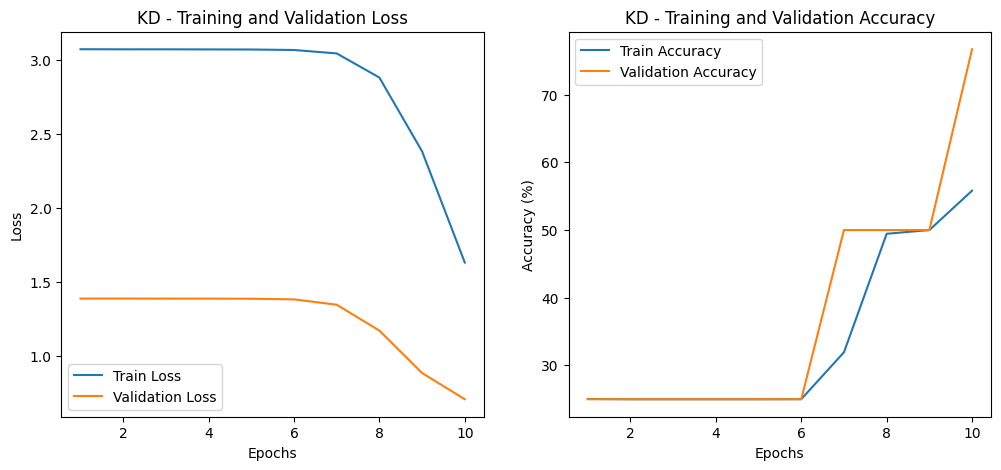

Step 1: Taylor expansion-based pruning
Taylor expansion-based pruning with threshold: 1e-06 applied.
Step 2: Structural pruning based on zero ratio
Pruned 12 filters/neuron(s) from conv1.
Pruned 6 filters/neuron(s) from conv2.
Pruned 13 filters/neuron(s) from conv3.
Pruned 23 filters/neuron(s) from conv4.
Pruned 778 filters/neuron(s) from fc1.
Pruned 93 filters/neuron(s) from fc2.
Skipping pruning for fc3 (output layer).
Structural pruning based on zero ratio applied. 925 filters/neuron(s) pruned in total.
Retraining after pruning


Epoch 1/11: 100%|██████████| 788/788 [00:05<00:00, 137.82batch/s, accuracy=65.4, loss=0.955]


Epoch [1/11], Loss: 0.9590, Accuracy: 65.44%, Val Loss: 0.7982, Val Accuracy: 72.91%


Epoch 2/11: 100%|██████████| 788/788 [00:05<00:00, 143.96batch/s, accuracy=89.2, loss=0.655]


Epoch [2/11], Loss: 0.7305, Accuracy: 89.21%, Val Loss: 0.6716, Val Accuracy: 91.89%


Epoch 3/11: 100%|██████████| 788/788 [00:05<00:00, 143.10batch/s, accuracy=92.4, loss=0.549]


Epoch [3/11], Loss: 0.6165, Accuracy: 92.44%, Val Loss: 0.5571, Val Accuracy: 97.72%


Epoch 4/11: 100%|██████████| 788/788 [00:05<00:00, 140.77batch/s, accuracy=94.9, loss=0.488]


Epoch [4/11], Loss: 0.5071, Accuracy: 94.94%, Val Loss: 0.4380, Val Accuracy: 97.15%


Epoch 5/11: 100%|██████████| 788/788 [00:05<00:00, 147.66batch/s, accuracy=96.8, loss=0.228]


Epoch [5/11], Loss: 0.3930, Accuracy: 96.76%, Val Loss: 0.3252, Val Accuracy: 98.46%


Epoch 6/11: 100%|██████████| 788/788 [00:05<00:00, 135.36batch/s, accuracy=98, loss=0.292]


Epoch [6/11], Loss: 0.2967, Accuracy: 97.97%, Val Loss: 0.2438, Val Accuracy: 98.83%


Epoch 7/11: 100%|██████████| 788/788 [00:05<00:00, 145.90batch/s, accuracy=98.8, loss=0.203]


Epoch [7/11], Loss: 0.2170, Accuracy: 98.78%, Val Loss: 0.1839, Val Accuracy: 98.91%


Epoch 8/11: 100%|██████████| 788/788 [00:05<00:00, 140.16batch/s, accuracy=98.9, loss=0.11]


Epoch [8/11], Loss: 0.1605, Accuracy: 98.94%, Val Loss: 0.1263, Val Accuracy: 99.35%


Epoch 9/11: 100%|██████████| 788/788 [00:05<00:00, 139.99batch/s, accuracy=99.1, loss=0.0827]


Epoch [9/11], Loss: 0.1173, Accuracy: 99.15%, Val Loss: 0.0935, Val Accuracy: 99.37%


Epoch 10/11: 100%|██████████| 788/788 [00:05<00:00, 149.11batch/s, accuracy=99.4, loss=0.0608]


Epoch [10/11], Loss: 0.0849, Accuracy: 99.36%, Val Loss: 0.0739, Val Accuracy: 99.31%


Epoch 11/11: 100%|██████████| 788/788 [00:05<00:00, 134.48batch/s, accuracy=99.4, loss=0.0777]


Epoch [11/11], Loss: 0.0647, Accuracy: 99.35%, Val Loss: 0.0826, Val Accuracy: 98.28%


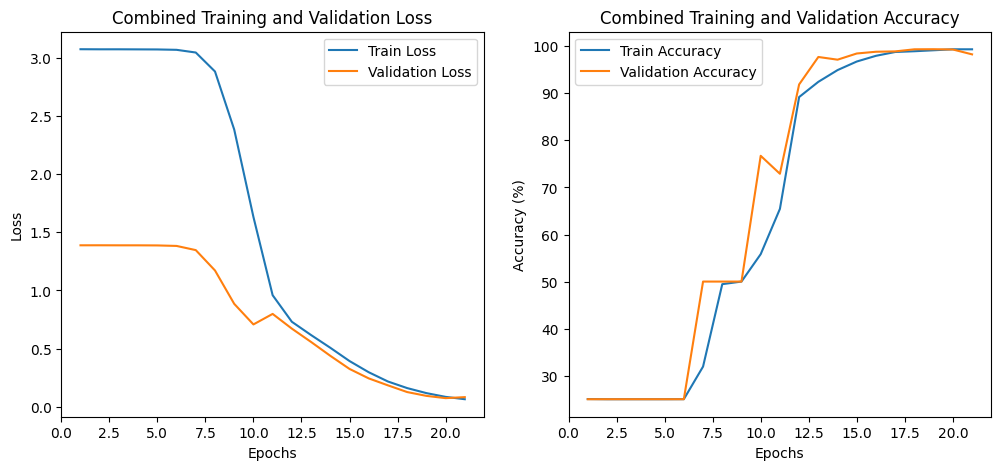

Final evaluation on the test set...
Final Test Loss: 0.0621, Final Test Accuracy: 99.26%


In [ ]:
pruned_student_model = prune_and_retrain(
    student_model=student_model,
    teacher_model=teacher_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    optimizer_params=optimizer_params_dict,
    threshold_taylor=0.000001,
    prune_threshold=0.95
)

In [ ]:
# 최종 테스트 정확도 출력
final_loss, final_accuracy = evaluate_model(teacher_model, test_loader, nn.CrossEntropyLoss())
print(f"\n[teacher Model Test Accuracy] {final_accuracy:.2f}%")


[teacher Model Test Accuracy] 98.48%


In [ ]:
# 모델 크기 출력
model_size = get_model_size(student_model)
print(f'Model size: {model_size:.2f} MB')

Model size: 2.09 MB


In [ ]:
# # 프루닝 및 재훈련 과정 함수 수정
# def prune_and_retrain(student_model, teacher_model, train_loader, val_loader, test_loader, criterion, device, optimizer_params, threshold_taylor=0.01, prune_threshold=0.7):
#     # 초기 옵티마이저 설정
#     student_optimizer = optim.Adam(student_model.parameters(), **optimizer_params)

#     # 초기 훈련
#     print("Initial training before pruning")
#     init_train_losses, init_val_losses, init_train_accuracies, init_val_accuracies =  train_kd(
#         student_model, teacher_model, train_loader, val_loader, student_optimizer, num_epochs=1, T=4.0, alpha=0.7)

#     # Step 1: Taylor 전개 기반 비구조적 프루닝
#     print("Step 1: Taylor expansion-based pruning")
#     # 프루닝을 위해 한 번의 forward 및 backward 패스를 수행하여 그래디언트 계산
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         student_optimizer.zero_grad()
#         outputs = student_model(inputs)
#         # Use the appropriate criterion for the initial pass before pruning
#         # For KD, this is typically the KD loss itself or just the hard loss
#         # Depending on how the loss in prune_by_taylor's gradient calculation is intended
#         # We'll use the KD loss here as it's used in train_kd
#         loss = distillation_loss(outputs, teacher_model(inputs.to(device)), labels, T=4.0, alpha=0.7) # Assuming same KD parameters
#         loss.backward()
#         break  # 한 배치만 필요함

#     # 마스크 없이 Taylor 기반 프루닝 적용
#     prune_by_taylor(student_model, threshold_taylor)

#     # Step 2: 0 비율 기반 구조적 프루닝
#     print("Step 2: Structural pruning based on zero ratio")
#     student_model = detect_and_apply_structural_pruning_with_zero_ratio(student_model, prune_threshold=prune_threshold, example_inputs=torch.randn(1, 1, input_length).to(device)) # Pass example_inputs with correct device

#     # 프루닝 후 재학습 (KD 사용)
#     optimizer = optim.Adam(student_model.parameters(), **optimizer_params)
#     print("Retraining after pruning")
#     retrain_train_losses, retrain_val_losses, retrain_train_accuracies, retrain_val_accuracies = train_kd( # Changed to train_kd
#         student_model, teacher_model, train_loader, val_loader, optimizer, num_epochs=11, T=4.0, alpha=0.7) # Added teacher_model and KD params

#     # 초기 훈련 및 재훈련의 손실과 정확도를 결합
#     total_train_losses = init_train_losses + retrain_train_losses
#     total_val_losses = init_val_losses + retrain_val_losses
#     total_train_accuracies = init_train_accuracies + retrain_train_accuracies
#     total_val_accuracies = init_val_accuracies + retrain_val_accuracies

#     # 통합 학습 곡선 시각화
#     plot_combined_learning_curves(total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies)

#     # 테스트 셋에 대한 최종 평가
#     print("Final evaluation on the test set...")
#     # Use CrossEntropyLoss for final evaluation, as it's a standard metric
#     test_loss, test_accuracy = evaluate_model(student_model, test_loader, nn.CrossEntropyLoss())
#     print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

#     return student_model